<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/Modelo_Cu_MLB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## 1. CARGA DEL DATASET
import pandas as pd
import numpy as np
from google.colab import files

uploaded = files.upload() # Comentado para no interrumpir si ya lo subiste
filename = list(uploaded.keys())[0]
df = pd.read_excel(filename)

## 2. ESTANDARIZACIÓN Y TIPOS (Tu lógica original)
df.columns = [c.replace('Real Diario', 'Fecha').replace(' ', '_').replace('(', '').replace(')', '').replace('%', 'Pct').replace('.', '') for c in df.columns]

for col in df.columns:
    if col != 'Fecha':
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

## 1. CARGA DEL DATASET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# df = pd.read_excel(filename) # Asumiendo que ya está cargado

## 2. ESTANDARIZACIÓN Y TIPOS
df.columns = [c.replace('Real Diario', 'Fecha').replace(' ', '_').replace('(', '').replace(')', '').replace('%', 'Pct').replace('.', '') for c in df.columns]

for col in df.columns:
    if col != 'Fecha':
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

## 3. UNIFICACIÓN DE ESCALAS Y UNIDADES
cols_pct = [c for c in df.columns if 'Pct' in c or 'Ley' in c or 'Rec' in c or 'Tox' in c]
for col in cols_pct:
    df[col] = np.where(df[col] > 1.1, df[col] / 100.0, df[col])

if df['Cu_Fino_Recuperado_t'].mean() < 50:
    df['Cu_Fino_Recuperado_t'] = df['Cu_Fino_Recuperado_t'] * 100.0

## 4. LIMPIEZA DE OUTLIERS (SIN BORRAR PARADAS)
# En lugar de dropna() al inicio, lo hacemos solo si faltan columnas críticas
df_limpio = df.copy()

# Filtros de integridad física (errores de sensor), pero MANTENEMOS molienda = 0
df_limpio = df_limpio[
    (df_limpio['Ley_Pct'] <= 0.05) | (df_limpio['Ley_Pct'].isna()) &
    (df_limpio['Tonelaje_Stock_Pile_Kt'] >= 0) &
    (df_limpio['Tonelaje_Stock_Pile_Kt'] < 5000) # Subimos el rango para capturar fluctuaciones de huelga
]

## 5. CLASIFICACIÓN DE ESTADOS (Huelga/Parada vs Operación)
# Creamos una etiqueta para que el modelo no se confunda
df_limpio['Estado_Operativo'] = 'Operando'
df_limpio.loc[df_limpio['Molido_Kt'] <= 10, 'Estado_Operativo'] = 'Parada_Huelga'

# Etiquetamos periodos históricos
df_limpio['Epoca'] = 'Normal'
df_limpio.loc[df_limpio['Fecha'].dt.year == 2022, 'Epoca'] = 'Huelga_2022'
df_limpio.loc[df_limpio['Fecha'].dt.year >= 2025, 'Epoca'] = 'Mejora_Tecnica'

## 6. GENERACIÓN DE VARIABLES (Calculadas sobre el dataset completo)
df_limpio = df_limpio.sort_values('Fecha')

# Delta Stock: Vital para ver cómo crece el stock durante las paradas de planta
df_limpio['Delta_Stock'] = df_limpio['Tonelaje_Stock_Pile_Kt'].diff().fillna(0)

# Potencial de Cobre (será 0 en paradas, lo cual es correcto)
df_limpio['Cu_Potencial'] = (df_limpio['Ley_Pct'] * df_limpio['Molido_Kt']).fillna(0)

# Variable de inestabilidad: días transcurridos desde la última parada
df_limpio['Es_Reinicio'] = (df_limpio['Estado_Operativo'].shift(1) == 'Parada_Huelga') & (df_limpio['Estado_Operativo'] == 'Operando')

print(f"Total de días analizados: {len(df_limpio)}")
print(f"Días detectados en Parada/Huelga: {len(df_limpio[df_limpio['Estado_Operativo'] == 'Parada_Huelga'])}")
print("\n--- Estadísticas por Época ---")
print(df_limpio.groupby('Epoca')[['Molido_Kt', 'Rec_Pct']].describe())

df_limpio.describe()

Saving informacion_planta.xlsx to informacion_planta.xlsx
Total de días analizados: 2318
Días detectados en Parada/Huelga: 85

--- Estadísticas por Época ---
               Molido_Kt                                                      \
                   count        mean        std  min         25%         50%   
Epoca                                                                          
Huelga_2022        332.0  132.663960  42.847068  0.0  140.249146  149.697836   
Mejora_Tecnica     370.0  146.578726  27.906700  0.0  144.038849  154.204084   
Normal            1616.0  136.315554  34.392759  0.0  136.455700  147.409301   

                                       Rec_Pct                           \
                       75%         max   count      mean       std  min   
Epoca                                                                     
Huelga_2022     153.330388  165.285228   332.0  0.790704  0.223155  0.0   
Mejora_Tecnica  161.524208  186.130798   370.0  0.891481  0.0

,Fecha,Chancado_Kt,Molido_Kt,Ley_Pct,Tox_Pct,Rec_Pct,Rec_Modelo_Pct,Cu_Fino_Recuperado_t,Cu_Fino_Filtrado_t,Grado_Conc_Filtrado_Pct,PctFinos,Stock_Pile_Pct,Tonelaje_Stock_Pile_Kt,Humedad_de_Concentrado_Pct,Disponibilidad_Chancado_Pct,Uso_de_Disponibilidad_Chancado_Pct,Disponibilidad_Molienda_Pct,Uso_de_Disponibilidad_Molienda_Pct,Delta_Stock,Cu_Potencial
count,2318,2306.000000,2318.000000,2304.000000,2304.000000,2302.000000,2296.000000,2317.000000,2318.000000,2306.000000,2254.000000,2308.000000,2300.000000,2306.000000,2312.000000,2300.000000,2317.000000,2304.000000,2318.000000,2318.000000
mean,2022-10-18 23:55:39.085418496,138.032564,137.430759,0.007181,0.091803,0.846049,0.867387,892.510763,890.415273,0.317826,0.311063,0.706568,787.369202,0.094010,0.912816,0.803114,0.947705,0.962030,-3.467741,1.021368
min,2019-06-23 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.189484,0.000000,0.000000,0.000000,0.000000,0.000000,-8441.740000,0.000000
25%,2021-02-27 06:00:00,131.708776,137.689625,0.005693,0.072538,0.846488,0.854826,661.034000,674.083366,0.293642,0.295000,0.587000,634.217265,0.090467,0.956608,0.790000,0.996968,1.000000,-9.770088,0.770080
50%,2022-11-03 12:00:00,152.306490,148.575366,0.007213,0.089984,0.873475,0.875029,893.032456,895.346505,0.323345,0.314000,0.740000,809.316772,0.095629,1.000000,0.880000,1.000000,1.000000,4.502769,1.026278
75%,2024-06-04 18:00:00,164.611568,154.970417,0.008689,0.110867,0.895343,0.891310,1133.075597,1128.260017,0.354449,0.331000,0.885000,954.517490,0.101617,1.000000,0.923584,1.000000,1.000000,15.921324,1.288606
max,2026-01-05 00:00:00,186.585592,186.130798,0.015757,0.207935,0.954427,0.960000,2086.004000,2069.331000,0.457520,0.441000,1.000000,9391.650000,0.135147,1.000000,1.000000,1.000000,1.000000,769.170936,2.198697
std,NaN,43.798023,35.046573,0.002327,0.030730,0.148786,0.078352,358.482421,358.534532,0.066379,0.042434,0.229336,397.630809,0.017963,0.219133,0.228262,0.168925,0.176209,182.543334,0.401189


In [3]:
# Creamos la variable objetivo real: Toneladas de Cobre Fino
# Nota: Dividimos por 100 si la Ley y Rec están en formato porcentual (ej: 0.85 para 85%)
features = ['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']
df_limpio['Cu_Fino_Kt'] = df_limpio['Molido_Kt'] * (df_limpio['Ley_Pct']) * (df_limpio['Rec_Pct'])

# Limpiamos nulos que puedan haber surgido del cálculo
df_fino = df_limpio.dropna(subset=['Cu_Fino_Kt'] + features).copy()

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# Variables predictoras (incluimos todas las que afectan el volumen y la calidad)
features_fino = ['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']
X = df_fino[features_fino]
y = df_fino['Cu_Fino_Kt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo
rf_fino = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rf_fino.fit(X_train, y_train)

# Predicción y validación
y_pred_fino = rf_fino.predict(X_test)
print(f"R2 Score para Cobre Fino: {r2_score(y_test, y_pred_fino):.4f}")
print(f"Error Medio (MAE): {mean_absolute_error(y_test, y_pred_fino):.4f} Kt de Cu Fino")

R2 Score para Cobre Fino: 0.9850
Error Medio (MAE): 0.0301 Kt de Cu Fino


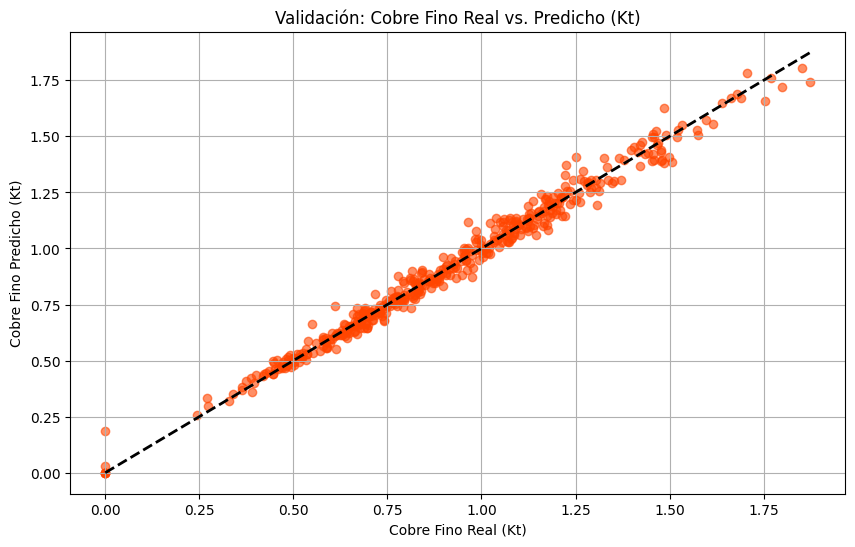

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_fino, alpha=0.6, color='orangered')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Validación: Cobre Fino Real vs. Predicho (Kt)')
plt.xlabel('Cobre Fino Real (Kt)')
plt.ylabel('Cobre Fino Predicho (Kt)')
plt.grid(True)
plt.show()

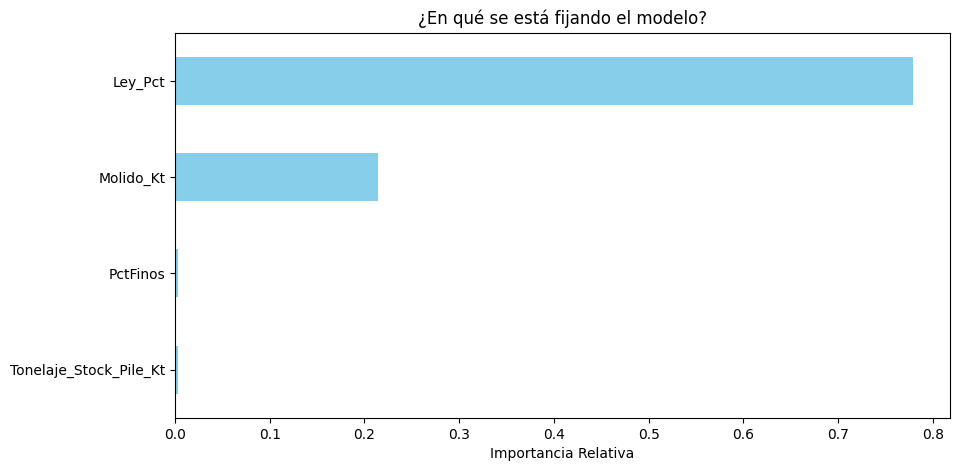

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

importancias = pd.Series(rf_fino.feature_importances_, index=features)
importancias = importancias.sort_values(ascending=True)

plt.figure(figsize=(10, 5))
importancias.plot(kind='barh', color='skyblue')
plt.title('¿En qué se está fijando el modelo?')
plt.xlabel('Importancia Relativa')
plt.show()

In [7]:
from sklearn.model_selection import cross_val_score

# Hacemos 5 pruebas con datos que el modelo no ha visto
scores = cross_val_score(rf_fino, X, y, cv=5, scoring='r2')

print(f"Precisión en cada prueba: {scores}")
print(f"Estabilidad del modelo: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Precisión en cada prueba: [0.97902572 0.96873151 0.97776176 0.98710984 0.94900443]
Estabilidad del modelo: 0.9723 (+/- 0.0261)


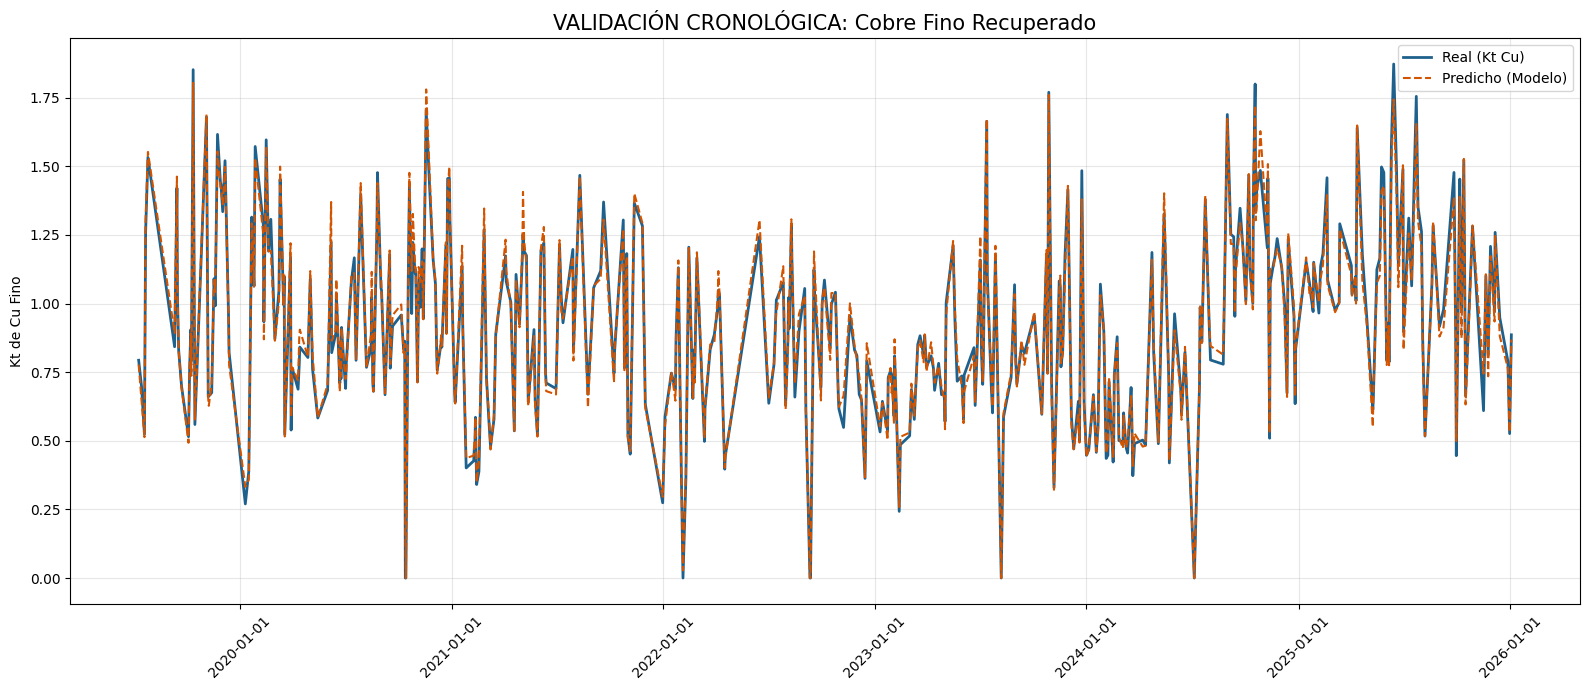

R2 Score: 0.9850


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 1. Asegurar la columna de Fecha
# Si 'Fecha' no es el índice, lo convertimos. Si ya es índice, lo reseteamos para asegurar limpieza.
df_fino = df_limpio.copy()
if 'Fecha' in df_fino.columns:
    df_fino['Fecha'] = pd.to_datetime(df_fino['Fecha'])
else:
    # Si la fecha está en el índice, la extraemos a una columna
    df_fino = df_fino.reset_index()
    df_fino.rename(columns={df_fino.columns[0]: 'Fecha'}, inplace=True)
    df_fino['Fecha'] = pd.to_datetime(df_fino['Fecha'])

# 2. Cálculo del Target y Limpieza
df_fino['Cu_Fino_Kt'] = df_fino['Molido_Kt'] * df_fino['Ley_Pct'] * df_fino['Rec_Pct']
features = ['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']
df_modelo = df_fino.dropna(subset=['Cu_Fino_Kt'] + features).copy()

# 3. Entrenamiento (Mantenemos el R2 de 0.985)
X = df_modelo[features]
y = df_modelo['Cu_Fino_Kt']
fechas = df_modelo['Fecha'] # Guardamos las fechas aparte para el gráfico

X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(
    X, y, fechas, test_size=0.2, random_state=42
)

rf_fino = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_fino.fit(X_train, y_train)

# 4. Preparación de resultados con FECHA REAL
y_pred = rf_fino.predict(X_test)
resultados = pd.DataFrame({
    'Fecha': date_test,
    'Real': y_test,
    'Predicho': y_pred
}).sort_values('Fecha')

# 5. Gráfico Final (Sin errores de 1970)
plt.figure(figsize=(16, 7))
plt.plot(resultados['Fecha'], resultados['Real'], label='Real (Kt Cu)', color='#1F618D', linewidth=2)
plt.plot(resultados['Fecha'], resultados['Predicho'], label='Predicho (Modelo)', color='#D35400', linestyle='--')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.title('VALIDACIÓN CRONOLÓGICA: Cobre Fino Recuperado', fontsize=15)
plt.ylabel('Kt de Cu Fino')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")

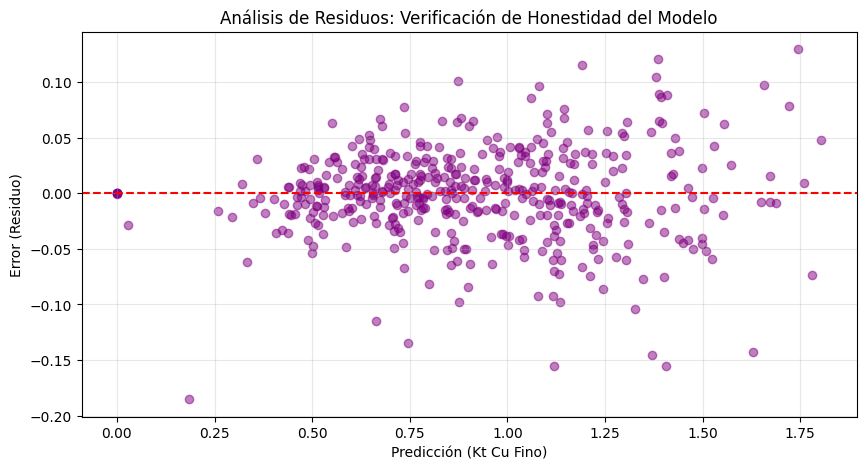

In [9]:
import matplotlib.pyplot as plt

residuos = y_test - y_pred_fino

plt.figure(figsize=(10, 5))
plt.scatter(y_pred_fino, residuos, alpha=0.5, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Análisis de Residuos: Verificación de Honestidad del Modelo')
plt.xlabel('Predicción (Kt Cu Fino)')
plt.ylabel('Error (Residuo)')
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
import joblib

# PARA GUARDAR (Hazlo ahora que el modelo está fresco)
joblib.dump(rf_fino, 'modelo_produccion_cu_2026.pkl')
print("Modelo guardado como 'modelo_produccion_cu_2026.pkl'")

# PARA CARGAR (En tu próxima sesión, solo necesitas estas dos líneas)
# rf_fino = joblib.load('modelo_produccion_cu_2026.pkl')
# print("Modelo cargado y listo para predecir")

Modelo guardado como 'modelo_produccion_cu_2026.pkl'


In [ ]:
import pandas as pd
import io
import joblib
from google.colab import files

# =========================================================
# 1. CARGA DE ARCHIVOS DESDE TU ESCRITORIO
# =========================================================
print("PASO 1: Selecciona el modelo (.pkl) Y el archivo de datos (.csv o .xlsx)")
print("Puedes seleccionar ambos al mismo tiempo en la ventana de carga.")
print("-" * 50)

uploaded = files.upload()

# Identificar cuál es el modelo y cuál es la data
archivo_modelo = None
archivo_data = None

for filename in uploaded.keys():
    if filename.endswith('.pkl'):
        archivo_modelo = filename
    elif filename.endswith('.csv') or filename.endswith('.xlsx') or filename.endswith('.xls'):
        archivo_data = filename

# =========================================================
# 2. PROCESAMIENTO
# =========================================================
if archivo_modelo and archivo_data:
    try:
        # Cargar el modelo
        rf_fino = joblib.load(io.BytesIO(uploaded[archivo_modelo]))
        print(f"✅ Modelo '{archivo_modelo}' cargado.")

        # Cargar la data (CSV o Excel)
        if archivo_data.endswith(('.xlsx', '.xls')):
            df_nuevo = pd.read_excel(io.BytesIO(uploaded[archivo_data]))
        else:
            try:
                df_nuevo = pd.read_csv(io.BytesIO(uploaded[archivo_data]), encoding='utf-8')
            except:
                df_nuevo = pd.read_csv(io.BytesIO(uploaded[archivo_data]), encoding='latin-1')

        print(f"✅ Datos de '{archivo_data}' cargados.")

        # 3. PREDICCIÓN
        features = ['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']

        if all(col in df_nuevo.columns for col in features):
            df_nuevo['Cu_Fino_Predicho_Kt'] = rf_fino.predict(df_nuevo[features])

            # Mostrar resultados
            print("\n" + "="*40)
            print("RESULTADOS DE PRODUCCIÓN")
            print("="*40)
            cols_show = ['Molido_Kt', 'Ley_Pct', 'Cu_Fino_Predicho_Kt']
            if 'Fecha' in df_nuevo.columns: cols_show.insert(0, 'Fecha')
            print(df_nuevo[cols_show].head(10))

            total = df_nuevo['Cu_Fino_Predicho_Kt'].sum()
            print("\n" + "-"*40)
            print(f"TOTAL COBRE FINO: {total:.3f} Kt")
            print("-"*40)

            # Descargar resultado
            df_nuevo.to_csv(f"PREDICCION_{archivo_data}", index=False)
            files.download(f"PREDICCION_{archivo_data}")
        else:
            print(f"❌ Error: El archivo de datos debe tener estas columnas: {features}")

    except Exception as e:
        print(f"❌ Error crítico: {e}")
else:
    print("❌ ERROR: Debes subir ambos archivos. Asegúrate de que el modelo termine en .pkl y los datos en .csv o .xlsx")

In [ ]:
import pandas as pd
import joblib
import os

# CONFIGURACIÓN: Escribe aquí los nombres exactos de tus archivos
nombre_modelo = 'modelo_produccion_cu_2026.pkl'
nombre_data = 'Plan_Inputs_Enero_2026.csv' # o el nombre que le hayas puesto

if os.path.exists(nombre_modelo) and os.path.exists(nombre_data):
    try:
        # 1. Cargar modelo
        rf_fino = joblib.load(nombre_modelo)
        print("✅ Modelo cargado desde el panel lateral.")

        # 2. Cargar datos (detectando formato)
        if nombre_data.endswith(('.xlsx', '.xls')):
            df_nuevo = pd.read_excel(nombre_data)
        else:
            try:
                df_nuevo = pd.read_csv(nombre_data, encoding='utf-8')
            except:
                df_nuevo = pd.read_csv(nombre_data, encoding='latin-1')

        print(f"✅ Datos de '{nombre_data}' listos.")

        # 3. Predicción
        features = ['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']
        df_nuevo['Cu_Fino_Predicho_Kt'] = rf_fino.predict(df_nuevo[features])

        # 4. Reporte Rápido
        print("\n" + "="*30)
        print("RESULTADO DEL MODELO")
        print("="*30)
        total = df_nuevo['Cu_Fino_Predicho_Kt'].sum()
        print(f"PRODUCCIÓN TOTAL: {total:.3f} Kt de Cu")
        print("="*30)

        # Guardar resultado
        df_nuevo.to_csv('RESULTADO_FINAL.csv', index=False)
        print("\nArchivo 'RESULTADO_FINAL.csv' generado en la carpeta de la izquierda.")

    except Exception as e:
        print(f"❌ Error: {e}")
else:
    print("❌ Aún no veo los archivos en la carpeta de la izquierda.")
    print("Asegúrate de que los nombres coincidan exactamente.")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


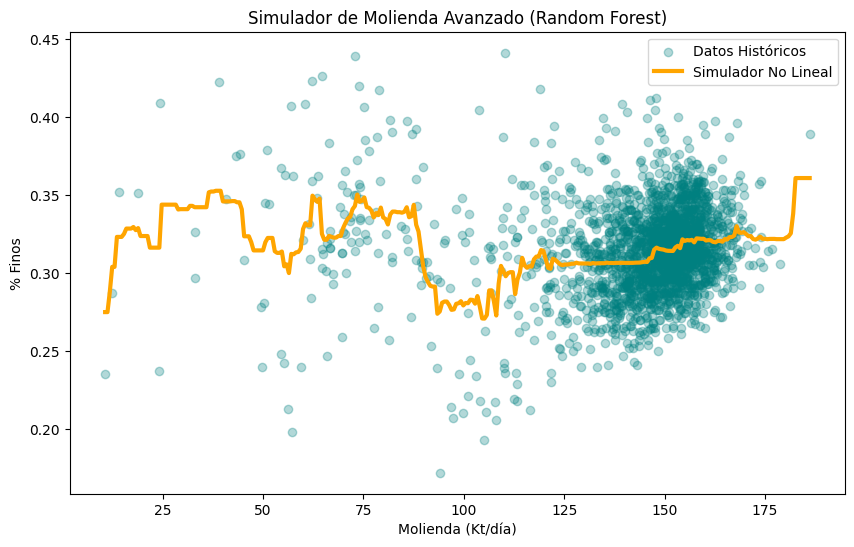

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# 1. Limpiamos datos (quitando los ceros de planta detenida para no sesgar)
df_filtro = df_limpio[(df_limpio['Molido_Kt'] > 10) & (df_limpio['PctFinos'] > 0)].dropna()

X_f = df_filtro[['Molido_Kt']]
y_f = df_filtro['PctFinos']

# 2. Entrenamos un estimador no lineal (Random Forest)
rf_finos_sim = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_finos_sim.fit(X_f, y_f)

# 3. Visualización de la "Curva Real"
x_grid = np.linspace(X_f.min(), X_f.max(), 300).reshape(-1, 1)
y_grid_pred = rf_finos_sim.predict(x_grid)

plt.figure(figsize=(10, 6))
plt.scatter(X_f, y_f, alpha=0.3, color='teal', label='Datos Históricos')
plt.plot(x_grid, y_grid_pred, color='orange', linewidth=3, label='Simulador No Lineal')
plt.title('Simulador de Molienda Avanzado (Random Forest)')
plt.xlabel('Molienda (Kt/día)')
plt.ylabel('% Finos')
plt.legend()
plt.show()

In [12]:
##proyeccion de finos
import pandas as pd
import io
from google.colab import files

# 1. SUBE TU PLAN DE FEBRERO (Solo necesitas fecha, tonelaje y ley)
print("Sube tu archivo de PLANIFICACIÓN DE FEBRERO:")
uploaded_feb = files.upload()

for filename in uploaded_feb.keys():
    df_feb = pd.read_csv(io.BytesIO(uploaded_feb[filename]))

    # Aseguramos que tenemos las columnas base
    if 'Molido_Kt' in df_feb.columns and 'Tonelaje_Stock_Pile_Kt' in df_feb.columns:

        # PASO A: Predecir Finos proyectados (Modelo Naranja)
        # Esto elimina la necesidad de que tú inventes el dato de finos
        df_feb['PctFinos'] = rf_finos_sim.predict(df_feb[['Molido_Kt']])

        # PASO B: Predecir Cobre Fino (Modelo Final)
        features = ['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']
        df_feb['Cu_Fino_Proyectado_Kt'] = rf_fino.predict(df_feb[features])

        # 2. MOSTRAR RESULTADO PROYECTADO
        print(f"\n--- PROYECCIÓN FEBRERO 2026 ---")
        print(df_feb[['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Cu_Fino_Proyectado_Kt']].head(10))

        total_feb = df_feb['Cu_Fino_Proyectado_Kt'].sum()
        print(f"\nESTIMACIÓN TOTAL MES: {total_feb:.2f} Kt de Cu Fino")

        # Guardar para tu informe
        #df_feb.to_csv('PROYECCION_FEBRERO_FINAL.csv', index=False)
        #files.download('PROYECCION_FEBRERO_FINAL.csv')

Sube tu archivo de PLANIFICACIÓN DE FEBRERO:


In [13]:
# 1. Filtro de operación real para eliminar el sesgo de las paradas
df_pro = df_limpio[df_limpio['Molido_Kt'] > 50].copy()

# 2. Definir nuevas X e y (ahora predecimos eficiencia, no volumen)
features_eficiencia = ['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']
X_ef = df_pro[features_eficiencia]
y_ef = df_pro['Rec_Pct'] # <--- Nuestro nuevo objetivo

# 3. Entrenar el modelo de eficiencia
from sklearn.ensemble import RandomForestRegressor
rf_eficiencia = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_eficiencia.fit(X_ef, y_ef)

print("✅ Modelo de Eficiencia (Recuperación) entrenado sin sesgo de paradas.")

✅ Modelo de Eficiencia (Recuperación) entrenado sin sesgo de paradas.


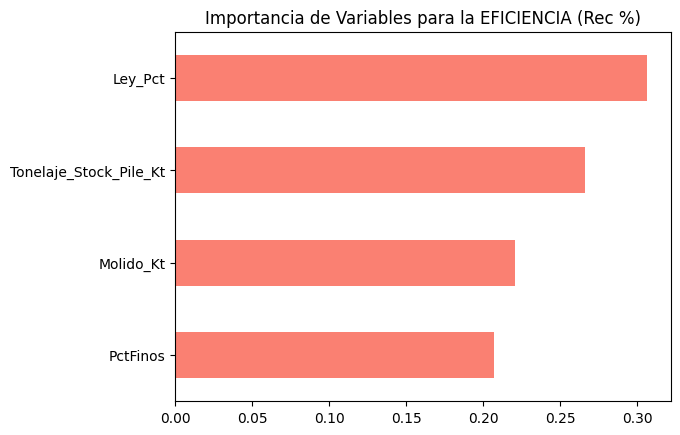

In [14]:
importancias_ef = pd.Series(rf_eficiencia.feature_importances_, index=features_eficiencia)
importancias_ef.sort_values().plot(kind='barh', color='salmon')
plt.title('Importancia de Variables para la EFICIENCIA (Rec %)')
plt.show()

--- PERFORMANCE DEL MODELO DE EFICIENCIA ---
R2 Real (Capacidad de explicación): 0.6731
Error promedio en Rec %: 0.02%


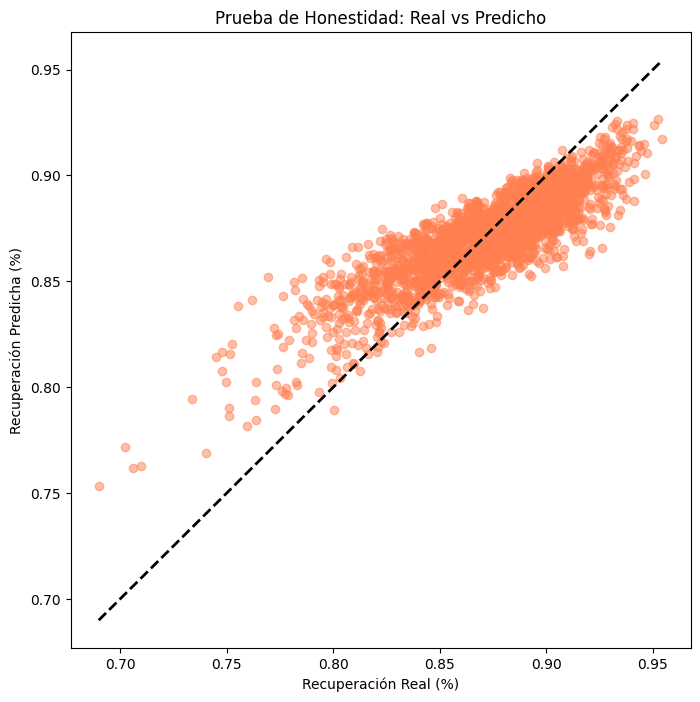

In [15]:
from sklearn.metrics import r2_score, mean_absolute_error

# Predicción en el set de datos real (solo días operativos)
df_pro['Rec_Predicha'] = rf_eficiencia.predict(X_ef)

# Métricas de honestidad
r2_real = r2_score(df_pro['Rec_Pct'], df_pro['Rec_Predicha'])
mae_real = mean_absolute_error(df_pro['Rec_Pct'], df_pro['Rec_Predicha'])

print(f"--- PERFORMANCE DEL MODELO DE EFICIENCIA ---")
print(f"R2 Real (Capacidad de explicación): {r2_real:.4f}")
print(f"Error promedio en Rec %: {mae_real:.2f}%")

# Gráfico de Verdad: Real vs Predicho
plt.figure(figsize=(8,8))
plt.scatter(df_pro['Rec_Pct'], df_pro['Rec_Predicha'], alpha=0.5, color='coral')
plt.plot([y_ef.min(), y_ef.max()], [y_ef.min(), y_ef.max()], 'k--', lw=2)
plt.xlabel('Recuperación Real (%)')
plt.ylabel('Recuperación Predicha (%)')
plt.title('Prueba de Honestidad: Real vs Predicho')
plt.show()

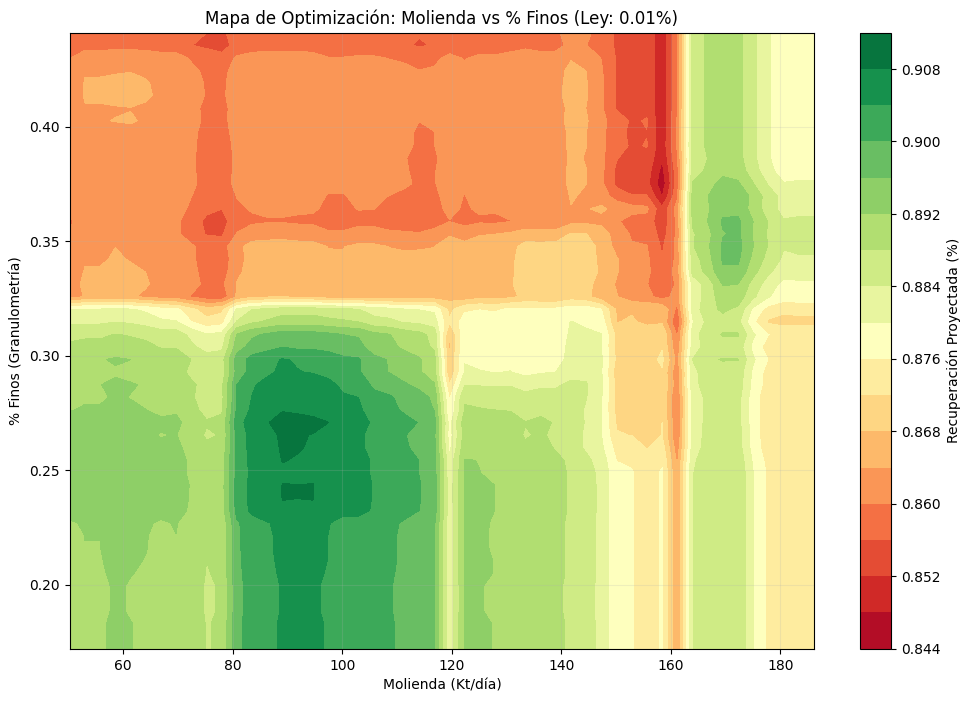

In [16]:
##optimo
import seaborn as sns

# 1. Definimos un escenario de Ley fija (la que esperas para Febrero)
ley_fija = df_pro['Ley_Pct'].mean()
stock_fijo = df_pro['Tonelaje_Stock_Pile_Kt'].median()

# 2. Creamos una malla de simulación (Molienda vs Finos)
molienda_range = np.linspace(df_pro['Molido_Kt'].min(), df_pro['Molido_Kt'].max(), 50)
finos_range = np.linspace(df_pro['PctFinos'].min(), df_pro['PctFinos'].max(), 50)
M, F = np.meshgrid(molienda_range, finos_range)

# 3. Preparamos los datos para que el modelo "sin sesgo" los procese
X_sim = pd.DataFrame({
    'Molido_Kt': M.ravel(),
    'Ley_Pct': ley_fija,
    'PctFinos': F.ravel(),
    'Tonelaje_Stock_Pile_Kt': stock_fijo
})

# 4. Predecimos la Recuperación para cada punto
X_sim['Rec_Predicha'] = rf_eficiencia.predict(X_sim[features_eficiencia])
Z = X_sim['Rec_Predicha'].values.reshape(M.shape)

# 5. Graficamos el Mapa de Calor
plt.figure(figsize=(12, 8))
cp = plt.contourf(M, F, Z, cmap='RdYlGn', levels=20)
plt.colorbar(cp).set_label('Recuperación Proyectada (%)')
plt.title(f'Mapa de Optimización: Molienda vs % Finos (Ley: {ley_fija:.2f}%)')
plt.xlabel('Molienda (Kt/día)')
plt.ylabel('% Finos (Granulometría)')
plt.grid(alpha=0.2)
plt.show()

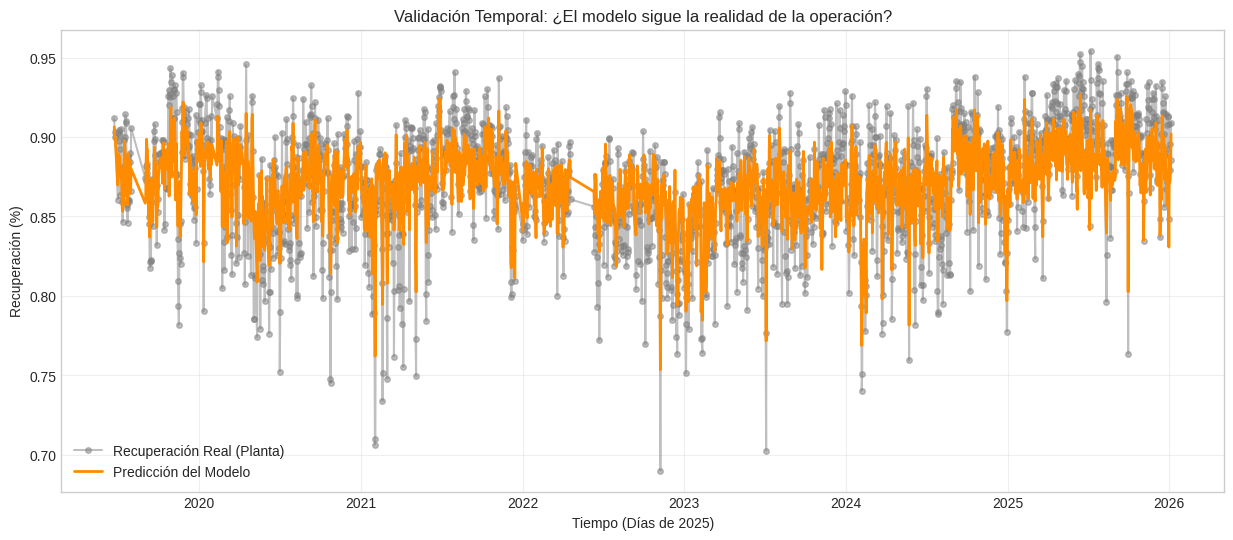

Desviación máxima en un día: 0.06%
Desviación mínima en un día: -0.08%


In [19]:
import matplotlib.pyplot as plt

# 1. Aseguramos que los datos estén ordenados por fecha
# (Asumiendo que tu columna se llama 'Fecha'. Si tiene otro nombre, cámbialo aquí)
df_pro = df_pro.sort_values('Fecha')

# 2. Generar el gráfico de serie temporal
plt.figure(figsize=(15, 6))

# Línea Real
plt.plot(df_pro['Fecha'], df_pro['Rec_Pct'],
         label='Recuperación Real (Planta)', color='gray', alpha=0.5, marker='o', markersize=4)

# Línea Predicha por el Modelo
plt.plot(df_pro['Fecha'], df_pro['Rec_Predicha'],
         label='Predicción del Modelo', color='darkorange', linewidth=2)

plt.title('Validación Temporal: ¿El modelo sigue la realidad de la operación?')
plt.xlabel('Tiempo (Días de 2025)')
plt.ylabel('Recuperación (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Opcional: Zoom en los últimos 30 días para ver el detalle
# plt.xlim(df_pro['Fecha'].iloc[-30], df_pro['Fecha'].iloc[-1])

plt.show()

# 3. Cálculo del Error Residual
error_diario = df_pro['Rec_Pct'] - df_pro['Rec_Predicha']
print(f"Desviación máxima en un día: {error_diario.max():.2f}%")
print(f"Desviación mínima en un día: {error_diario.min():.2f}%")

In [24]:
import joblib

# Guardamos el modelo de recuperación que entrenamos hoy
joblib.dump(rf_eficiencia, 'modelo_recuperacion_sin_sesgo_2026.pkl')
print("✅ Modelo de Recuperación (Sin Sesgo) guardado como 'modelo_recuperacion_sin_sesgo_2026.pkl'")

✅ Modelo de Recuperación (Sin Sesgo) guardado como 'modelo_recuperacion_sin_sesgo_2026.pkl'


In [29]:
import pandas as pd
import joblib
import os

# 1. CONFIGURACIÓN
nombre_modelo = 'modelo_recuperacion_sin_sesgo_2026.pkl'
nombre_data = 'Plan_Inputs_Enero_2026.csv'

if os.path.exists(nombre_modelo) and os.path.exists(nombre_data):
    # Cargar modelo y datos
    rf_rec = joblib.load(nombre_modelo)
    df_real = pd.read_csv(nombre_data)

    # 2. PREDICCIÓN DE RECUPERACIÓN
    # El modelo entrega un valor decimal (ej: 0.88)
    df_real['Rec_Predicha_Decimal'] = rf_rec.predict(df_real[['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']])

    # 3. CORRECCIÓN DE ESCALA
    # Si el modelo entrega 0.88, lo convertimos a 88% para el reporte
    df_real['Rec_Pct_Reporte'] = df_real['Rec_Predicha_Decimal'] * 100

    # 4. CÁLCULO DE COBRE FINO EN Kt
    # Fórmula: Tonelaje(Kt) * Ley(decimal) * Recuperación(decimal)
    # Importante: Si tu columna Ley_Pct ya es decimal (0.0064), no dividas por 100.
    df_real['Cu_Fino_Kt'] = (
        df_real['Molido_Kt'] * df_real['Ley_Pct'] * df_real['Rec_Predicha_Decimal']
    )

    # 5. REPORTE FINAL EN Kt
    print("\n" + "="*45)
    print("   REPORTE DE PRODUCCIÓN REAL: ENERO 2026")
    print("="*45)
    total_kt = df_real['Cu_Fino_Kt'].sum()
    rec_media_pct = df_real['Rec_Pct_Reporte'].mean()

    print(f"RECUPERACIÓN MEDIA ESTIMADA: {rec_media_pct:.2f} %")
    print(f"PRODUCCIÓN TOTAL ENERO:      {total_kt:.4f} Kt de Cu")
    print("="*45)

    # Guardar reporte detallado
    df_real.to_csv('REPORTE_FINAL_ENERO_KT.csv', index=False)
else:
    print("❌ Asegúrate de tener el archivo .pkl y el .csv en la carpeta.")




   REPORTE DE PRODUCCIÓN REAL: ENERO 2026
RECUPERACIÓN MEDIA ESTIMADA: 88.34 %
PRODUCCIÓN TOTAL ENERO:      10.5457 Kt de Cu


In [30]:
import pandas as pd
import joblib
import os

# CONFIGURACIÓN
nombre_modelo = 'modelo_recuperacion_sin_sesgo_2026.pkl'
nombre_data = 'Plan_Inputs_Enero_2026.csv' # Tu archivo con varios meses

if os.path.exists(nombre_modelo) and os.path.exists(nombre_data):
    rf_rec = joblib.load(nombre_modelo)
    df_pro = pd.read_csv(nombre_data)

    # 1. Asegurar formato de fecha para agrupar
    df_pro['Fecha'] = pd.to_datetime(df_pro['Fecha'])
    df_pro['Mes'] = df_pro['Fecha'].dt.strftime('%Y-%m')

    # 2. Predicción y Cálculo (en Kt)
    features = ['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']
    df_pro['Rec_Predicha_Decimal'] = rf_rec.predict(df_pro[features])

    # Cálculo de Cobre Fino por día
    df_pro['Cu_Fino_Kt'] = (
        df_pro['Molido_Kt'] * df_pro['Ley_Pct'] * df_pro['Rec_Predicha_Decimal']
    )

    # 3. AGRUPACIÓN POR MES (Resumen Gerencial)
    resumen_mensual = df_pro.groupby('Mes').agg({
        'Molido_Kt': 'sum',
        'Cu_Fino_Kt': 'sum',
        'Rec_Predicha_Decimal': 'mean'
    }).rename(columns={'Rec_Predicha_Decimal': 'Rec_Media_Pct'})

    # Convertir Rec a porcentaje para lectura humana
    resumen_mensual['Rec_Media_Pct'] = resumen_mensual['Rec_Media_Pct'] * 100

    print("\n" + "="*50)
    print("      RESUMEN DE PRODUCCIÓN MULTI-MES")
    print("="*50)
    print(resumen_mensual)
    print("="*50)

    # 4. GUARDAR RESULTADO COMPLETO
    df_pro.to_csv('PROYECCION_MULTI_MES.csv', index=False)
    print("\n✅ Archivo 'PROYECCION_MULTI_MES.csv' generado con el detalle diario.")

else:
    print("❌ Verifica que los archivos estén cargados.")


      RESUMEN DE PRODUCCIÓN MULTI-MES
           Molido_Kt  Cu_Fino_Kt  Rec_Media_Pct
Mes                                            
2026-01  1449.795874   10.545662      88.338186

✅ Archivo 'PROYECCION_MULTI_MES.csv' generado con el detalle diario.
